In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from simple_abstractor import SimpleAbstractorEncoderLayer, SimpleAbstractorEncoder
from set_models import SetCNNEmbedder, SetClassifierLayer, SetSequenceModel
from set_data_lit import SetCardDataModule, SetTriplesDataModule
from set_data import SetCardBaseDataset, SetTriplesDataset
import os

In [2]:
label_choice = "triple_sim"
seq_len = 3
n_features = 2

ds = SetCardBaseDataset(n_features=n_features)
dm = SetTriplesDataModule(ds,label_choice=label_choice, 
                          balanced_sampling=True,
                          val_split=0.001, 
                          test_split=0)
dm.setup()

/home/job/miniconda3/envs/LTN/lib/python3.9/site-packages/torch/utils/data/dataset.py:472: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(


NameError: name 'Counter' is not defined

In [ ]:
for batch in dm.train_dataloader():
    x, y = batch
    print(y.shape)
    print(torch.bincount(y))
    break

torch.Size([32, 2])


RuntimeError: bincount only supports 1-d non-negative integral inputs.

In [2]:
n_features = 2

embedder_kwargs = dict(hidden_dim=128, embed_dim=2)
label_choice = "features"
cnn = torch.load("./cnn_checkpoints/cnn.pt")
ds = SetCardBaseDataset(image_embedder=cnn, n_features=n_features)
dm = SetCardDataModule(
        ds,
        batch_size=64,
        val_split=0,
        test_split=0.,
    )
dm.setup()

/home/job/miniconda3/envs/LTN/lib/python3.9/site-packages/torch/utils/data/dataset.py:472: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(
/home/job/miniconda3/envs/LTN/lib/python3.9/site-packages/torch/utils/data/dataset.py:472: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(


In [ ]:
def load_2D_input(label_choice="features"):
    cnn = torch.load("./cnn_checkpoints/cnn.pt")
    classifier = torch.load("./checkpoints/2dclassifier.pt")
    return cnn, classifier

def prep_2d(cnn, classifier, label_choice, seq_len, n_features=1):
    seq_model = SetSequenceModel(classifier=classifier, seq_len=1, label_choice=label_choice, n_features=n_features)
    ds = SetCardBaseDataset(image_embedder=cnn, n_features=n_features)
    return seq_model, ds

In [3]:

classifier = SetClassifierLayer(
                label_choice=label_choice,
                embed_dim=cnn.embed_dim,
                seq_len=1,
                hidden_sizes=[2],
                n_features = n_features
            )

seq_model = SetSequenceModel(base_embedder=None, classifier=classifier, seq_len=1, label_choice=label_choice, n_features=n_features, lr=0.01)

logger = WandbLogger(project="first_project", name="2features")
trainer_kwargs = dict(max_epochs=250, logger=logger, 
                    #   callbacks=[EarlyStopping(monitor="val_loss", mode="min")],
                                        #   val_check_interval=25, 
                        check_val_every_n_epoch=1
                        )

trainer = pl.Trainer(**trainer_kwargs)
trainer.fit(seq_model, dm)

logger.experiment.finish()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jjhlgraber (jjhlgraber-University of Amsterdam). Use `wandb login --relogin` to force relogin


/home/job/miniconda3/envs/LTN/lib/python3.9/site-packages/torch/utils/data/dataset.py:472: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(
/home/job/miniconda3/envs/LTN/lib/python3.9/site-packages/torch/utils/data/dataset.py:472: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | embedder      | Sequential         | 0      | train
1 | aggregate_seq | Flatten            | 0      | train
2 | final_layer   | SetClassifierLayer | 148    | train
-------------------------------------------------------------
148       Trainable params
0         Non-trainable params
148       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/job/miniconda3/envs/LTN/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:105: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.
/home/job/miniconda3/envs/LTN/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=250` reached.


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▅▃▄▂▂▁▂▁
trainer/global_step,▁▂▃▃▄▅▆▆▇█
epoch,249
train_loss,0.08138
trainer/global_step,499


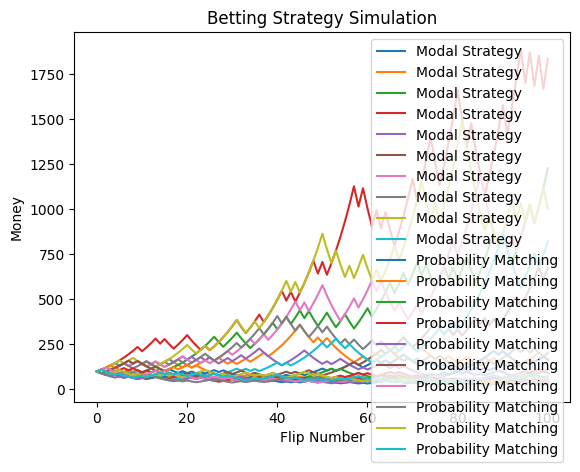

In [1]:
def plot_2d(classifier, embeds, labels):

    # Get the range for x and y from the output of before_last_linear
    with torch.no_grad():
        before_last_linear = classifier.layers[:-1](embeds)
    x_min, x_max = before_last_linear[:, 0].min().item(), before_last_linear[:, 0].max().item()
    y_min, y_max = before_last_linear[:, 1].min().item(), before_last_linear[:, 1].max().item()

    # Create the meshgrid using the calculated range
    x, y = torch.meshgrid(torch.linspace(x_min, x_max, 100), 
                        torch.linspace(y_min, y_max, 100))

    # Stack x and y to create a 2D input tensor
    input_tensor = torch.stack((x.flatten(), y.flatten()), dim=1)

    # Get predictions
    with torch.no_grad():
        logits = classifier.layers[-1](input_tensor)
    probs = nn.Softmax(-1)(logits.view(-1, 2, 3))
    preds = probs.argmax(-1)

    # Define color and marker dictionaries
    marker_dict = {0: '1', 1: '2', 2: '3'}
    color_dict = {0: 'red', 1: 'green', 2: 'purple'}

    # Create the plots
    fig, axs = plt.subplots(4, 3, figsize=(15, 20))  # 2 rows, 3 columns

    # Plot for original data with labels
    for i in range(len(before_last_linear)):
        color = color_dict[labels[i, 1].item()]
        marker = marker_dict[labels[i, 0].item()]
        axs[0, 0].scatter(before_last_linear[i, 0], before_last_linear[i, 1], c=color, marker=f'${marker}$')

    axs[0, 0].set_xlabel("X-axis")
    axs[0, 0].set_ylabel("Y-axis")
    axs[0, 0].set_title("2D Data with Two Labels")

    pred_label1 = preds[:, 0]
    pred_label2 = preds[:, 1]

    subset_indices = torch.randperm(len(pred_label1))[:500]
    pred_label1_sub = pred_label1[subset_indices]
    pred_label2_sub = pred_label2[subset_indices]
    input_tensor_sub = input_tensor[subset_indices]

    for i in range(3):
        marker = marker_dict[i]
        for j in torch.where(pred_label1_sub == i):
            axs[1, 0].scatter(input_tensor_sub[j, 0], input_tensor_sub[j, 1], c=[color_dict[c.item()] for c in pred_label2_sub[j]], marker=f'${marker}$'
                            )


    # Plot for Label 1 predictions
    axs[1,1].scatter(input_tensor[:, 0], input_tensor[:, 1], c=[color_dict[c.item()] for c in pred_label1]
                    #  , marker=[f'${marker_dict[c.item()]}$' for c in pred_label1]
                    )
    axs[1,1].set_title('Label 1 Predictions')

    # Plot for Label 2 predictions
    axs[1,2].scatter(input_tensor[:, 0], input_tensor[:, 1], c=[color_dict[c.item()] for c in pred_label2])
    axs[1,2].set_title('Label 2 Predictions')

    # Plots for individual class probabilities
    for i in range(3):
        axs[2, i].scatter(input_tensor[:, 0], input_tensor[:, 1], c=probs[:, 0, i], cmap='viridis')
        axs[2, i].set_title(f'Probability of {marker_dict[i]}')

    for i in range(3):
        axs[3, i].scatter(input_tensor[:, 0], input_tensor[:, 1], c=probs[:, 1, i], cmap='plasma')
        axs[3, i].set_title(f'Probability of Class {color_dict[i]}')

    plt.tight_layout()
    plt.show()


plot_2d(seq_model.final_layer, ds.card_embeds, ds.card_feature_vectors)

In [ ]:
assert False

In [4]:
embedder_kwargs=dict()
abstractor_kwargs = {
    "num_layers": 2,
    "norm": None,  # Example normalization layer
    "use_pos_embedding": False,
    "use_learned_symbols": True,
    "object_dim": 64,
    "symbol_dim": 32,  # Using a different symbol dimension
    "num_heads": 4,
    "ff_dim": 128,
    "dropout": 0.1,
    "MHA_kwargs": {
        "use_bias": False,
        "activation": nn.Identity(-1),  # Different activation function
        "use_scaling": True,
        "shared_kv_proj": True,
    },
}

label_choice = "is_set"

In [5]:
ds = SetCardBaseDataset()
dm = SetTriplesDataModule(
        ds,
        batch_size=64,
        label_choice=label_choice,
        balanced_sampling=True,  # Enable balanced sampling
        val_split=0.1,
        test_split=0.,
    )
dm.setup()

# cnn = SetCNNEmbedder()
cnn = torch.load("./cnn_checkpoints/cnn.pt")
# cnn.load_state_dict(checkpoint['model_state_dict'])
AE = SimpleAbstractorEncoder(**abstractor_kwargs)

seq_model = SetSequenceModel(base_embedder=cnn, contextual_embedder=AE, seq_len=3, label_choice=label_choice)


logger = WandbLogger(project="first_project", name="2 layers")
trainer_kwargs = dict(max_epochs=25, logger=logger, 
                    #   callbacks=[EarlyStopping(monitor="val_loss", mode="min")],
                                        #   val_check_interval=25, 
                        check_val_every_n_epoch=1
                        )

trainer = pl.Trainer(**trainer_kwargs)
trainer.fit(seq_model, dm)

logger.experiment.finish()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                    | Params | Mode 
------------------------------------------------------------------------
0 | base_embedder       | SetCNNEmbedder          | 41.3 K | train
1 | contextual_embedder | SimpleAbstractorEncoder | 25.2 K | train
2 | embedder            | Sequential              | 66.5 K | train
3 | aggregate_seq       | Flatten                 | 0      | train
4 | final_layer         | SetClassifierLayer      | 97     | train
5 | accuracy            | BinaryAccuracy          | 0      | train
------------------------------------------------------------------------
66.6 K    Trainable params
0         Non-trainable params
66.6 K    Total params
0.266     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/job/miniconda3/envs/LTN/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/job/miniconda3/envs/LTN/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


epoch,▁▅▅█
train_loss,▁
trainer/global_step,▁▃▅█
val_acc,▁▆█
val_loss,█▄▁
epoch,2
train_loss,0.55348
trainer/global_step,89
val_acc,0.69672
val_loss,0.57022
